# Early environment setup


In [1]:
! pip install transformers
! pip install pycaret


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 475.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.

In [1]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")

In [2]:
# Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Fakenews/

/content/drive/MyDrive/Fakenews


In [4]:
# Load Dataset
true_data = pd.read_csv('/content/drive/MyDrive/dataset/True.csv')
fake_data = pd.read_csv('/content/drive/MyDrive/dataset/Fake.csv')

# Generate labels True/Fake under new Target Column in 'true_data' and 'fake_data'
true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

# Merge 'true_data' and 'fake_data', by random mixing into a single df called 'data'
data = pd.concat([true_data, fake_data]).sample(frac=1).reset_index(drop=True)

# See how the data looks like
print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,Target
0,Watch Bill Maher Absolutely SHRED Trump For T...,"Bill Maher LOVES ripping Donald Trump apart, a...",News,"April 23, 2016",Fake
1,"After euro zone, Germany's Schaeuble faces new...",BERLIN (Reuters) - In his eight years as Germa...,worldnews,"September 27, 2017",True
2,Apparently The Speaker Of The House Is Now Ta...,Just when you thought Republicans couldn t get...,News,"February 24, 2016",Fake
3,"Lebanon ex-PM meets French, UK, EU, U.S. diplo...","BEIRUT (Reuters) - Saad al-Hariri, who resigne...",worldnews,"November 9, 2017",True
4,FOX NEWS’ SHEPARD SMITH Has Liberal Meltdown O...,"Like Megyn Kelly, who lost her supporters when...",politics,"Feb 16, 2017",Fake


In [5]:
# Target column is made of string values True/Fake, let's change it to numbers 0/1 (Fake=1)
data['label'] = (data['Target'] == 'Fake').astype(int)


In [6]:
data.head()


,title,text,subject,date,Target,label
0,Watch Bill Maher Absolutely SHRED Trump For T...,"Bill Maher LOVES ripping Donald Trump apart, a...",News,"April 23, 2016",Fake,1
1,"After euro zone, Germany's Schaeuble faces new...",BERLIN (Reuters) - In his eight years as Germa...,worldnews,"September 27, 2017",True,0
2,Apparently The Speaker Of The House Is Now Ta...,Just when you thought Republicans couldn t get...,News,"February 24, 2016",Fake,1
3,"Lebanon ex-PM meets French, UK, EU, U.S. diplo...","BEIRUT (Reuters) - Saad al-Hariri, who resigne...",worldnews,"November 9, 2017",True,0
4,FOX NEWS’ SHEPARD SMITH Has Liberal Meltdown O...,"Like Megyn Kelly, who lost her supporters when...",politics,"Feb 16, 2017",Fake,1


([<matplotlib.patches.Wedge at 0x7be915fe5590>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

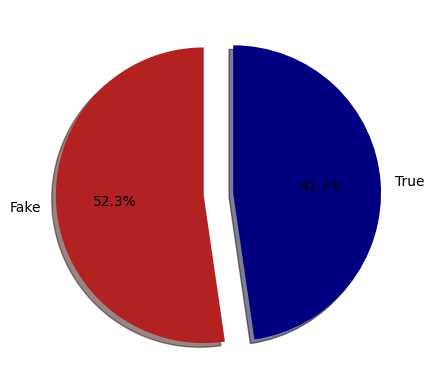

In [7]:
# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

In [8]:
# Train-Validation-Test set split into 80:10:10 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.2,
                                                                    stratify=data['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

# Data tokenize


In [9]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Text(0, 0.5, 'Number of texts')

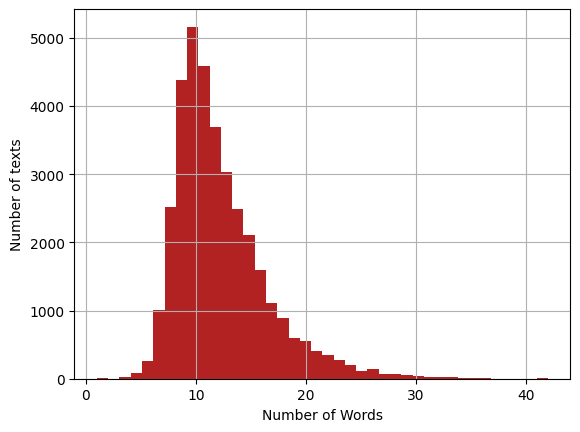

In [10]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [11]:
# BERT Tokeizer Functionality
sample_data = ["Build fake news model.",
               "Using bert."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     # encode text
print(tokenized_sample_data)


{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [12]:
# 40 should cover most of the news
MAX_LENGTH = 40



In [13]:
tokens_train = tokenizer(train_text.tolist(), max_length=MAX_LENGTH, padding="max_length", truncation=True, return_tensors="pt")
tokens_val   = tokenizer(val_text.tolist(),   max_length=MAX_LENGTH, padding="max_length", truncation=True, return_tensors="pt")
tokens_test  = tokenizer(test_text.tolist(),  max_length=MAX_LENGTH, padding="max_length", truncation=True, return_tensors="pt")

In [14]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(tokens_train["input_ids"], tokens_train["attention_mask"], torch.tensor(train_labels.tolist()))    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(tokens_val["input_ids"], tokens_val["attention_mask"], torch.tensor(val_labels.tolist()))            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                      # dataLoader for validation set

# partially frozen-BERT-based transfer learning (Freezing pre-trained layer approach)( 2 custom output layers added)

# Model Architecture (self defined Classifier)


In [15]:
# Freeze all layers
for param in bert.parameters():
    param.requires_grad = False

# Unfreeze last 2 encoder layers
for name, param in bert.encoder.layer.named_parameters():
    layer_num = int(name.split('.')[0])
    if layer_num >= 10:  # last 2 layers = layer 10 and 11
        param.requires_grad = True

# Also unfreeze pooler if you're using pooler_output
for param in bert.pooler.parameters():
    param.requires_grad = True

In [138]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from torch.optim import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 3

# training function

[連結文字](https://)

In [105]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0
  model.to(device)
  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    sent_id, mask, labels = [x.to(device) for x in batch]
    #batch = [r for r in batch]                                  # push the batch to gpu
    #sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  model.to(device)
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
    sent_id, mask, labels = [x.to(device) for x in batch]
                                                  # Report progress
    # batch = [t for t in batch]                    # Push the batch to GPU
    # sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [131]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(3):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'fake_news_model.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 3
  Batch    50  of  1,123.
  Batch   100  of  1,123.
  Batch   150  of  1,123.
  Batch   200  of  1,123.
  Batch   250  of  1,123.
  Batch   300  of  1,123.
  Batch   350  of  1,123.
  Batch   400  of  1,123.
  Batch   450  of  1,123.
  Batch   500  of  1,123.
  Batch   550  of  1,123.
  Batch   600  of  1,123.
  Batch   650  of  1,123.
  Batch   700  of  1,123.
  Batch   750  of  1,123.
  Batch   800  of  1,123.
  Batch   850  of  1,123.
  Batch   900  of  1,123.
  Batch   950  of  1,123.
  Batch 1,000  of  1,123.
  Batch 1,050  of  1,123.
  Batch 1,100  of  1,123.

Evaluating...
  Batch    50  of    141.
  Batch   100  of    141.

Training Loss: 0.075
Validation Loss: 0.054


# performance evaluation


In [132]:
with torch.no_grad():
  preds = model(tokens_test['input_ids'].to(device), tokens_test['attention_mask'].to(device))
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(torch.tensor(test_labels.tolist()), preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2142
           1       0.98      0.98      0.98      2348

    accuracy                           0.98      4490
   macro avg       0.98      0.98      0.98      4490
weighted avg       0.98      0.98      0.98      4490



# sampling


In [137]:
# Unseen news headline

unseen_news_text = [
    # Real News
    "NASA's James Webb Space Telescope has discovered the most distant galaxy ever observed, dating back to just 300 million years after the Big Bang.",
    "India successfully landed its Chandrayaan-3 mission on the Moon's south pole, becoming the first country to do so.",
    "The European Union fined Meta €1.2 billion for violating GDPR by transferring user data to the U.S. without proper safeguards.",
    "WHO officially declared COVID-19 is no longer a global public health emergency in May 2023.",
    "Brazil's Amazon deforestation dropped by over 30% in the first half of 2023, following renewed environmental policies under President Lula.",

    # Fake / Ambiguous News
    "Scientists in Switzerland claim they have successfully transferred human consciousness into a USB stick during an AI experiment.",
    "A startup in Silicon Valley is offering genetically modified wings to humans for $25,000, claiming it enables short-range flight.",
    "Japan has announced it will build a second Mount Fuji using 3D printing to promote tourism and test volcano resilience.",
    "A leaked UN document reveals that time travel was discovered in 1987 but has been kept classified by global powers.",
    "Scientists discovered a new planet in our solar system composed entirely of cheese, visible only during lunar eclipses."
]

# Tokenize using modern API and return PyTorch tensors
MAX_LENGTH = 15
tokens_unseen = tokenizer(
    unseen_news_text,
    max_length=MAX_LENGTH,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

# Move inputs to device (e.g. GPU)
unseen_seq = tokens_unseen["input_ids"].to(device)
unseen_mask = tokens_unseen["attention_mask"].to(device)

# Predict
model.eval()
with torch.no_grad():
    preds = model(unseen_seq, unseen_mask)
    preds = torch.argmax(preds, dim=1).cpu().numpy()

print(preds)

[0 0 0 1 0 0 1 0 1 1]


# saved trained model


RuntimeError: Parent directory /content/drive/MyDrive/bert_models does not exist.

In [61]:
# IF CPU
# model = BERT_Arch(bert)
# model = model.to("cpu")
# model.load_state_dict(torch.load("/content/drive/MyDrive/Fakenews_prj/fake_news_model.pt", map_location=torch.device("cpu")))
# model.eval()


model = BERT_Arch(bert)
model.load_state_dict(torch.load("/content/drive/MyDrive/Fakenews/fake_news_model.pt"))
model = model.to(device)
model.eval()

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff